__Using the same code as given in the lectures to begin with__

In [1]:
data_location = 'sqlite:///../../../data/data.db'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce

import pickle

In [3]:
def vol_ohlc(df, lookback=10):
    o = df.open
    h = df.high
    l = df.low
    c = df.close
    
    k = 0.34 / (1.34 + (lookback+1)/(lookback-1))
    cc = np.log(c/c.shift(1))
    ho = np.log(h/o)
    lo = np.log(l/o)
    co = np.log(c/o)
    oc = np.log(o/c.shift(1))
    oc_sq = oc**2
    cc_sq = cc**2
    rs = ho*(ho-co)+lo*(lo-co)
    close_vol = cc_sq.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    open_vol = oc_sq.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    window_rs = rs.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    result = (open_vol + k * close_vol + (1-k) * window_rs).apply(np.sqrt) * np.sqrt(252)
    result[:lookback-1] = np.nan
    
    return result

In [4]:
def plot_learning_curve(
    estimator,
    title,
    X,
    y,
    axes=None,
    ylim=None,
    cv=None,
    n_jobs=None,
    train_sizes=np.linspace(0.1, 1.0, 5),
    scoring=None
):
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        estimator,
        X,
        y,
        cv=cv,
        n_jobs=n_jobs,
        train_sizes=train_sizes,
        return_times=True,
        scoring=scoring,
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    axes[0].fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    axes[0].plot(
        train_sizes, train_scores_mean, "o-", color="r", label="Training score"
    )
    axes[0].plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, "o-")
    axes[1].fill_between(
        train_sizes,
        fit_times_mean - fit_times_std,
        fit_times_mean + fit_times_std,
        alpha=0.1,
    )
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    fit_time_argsort = fit_times_mean.argsort()
    fit_time_sorted = fit_times_mean[fit_time_argsort]
    test_scores_mean_sorted = test_scores_mean[fit_time_argsort]
    test_scores_std_sorted = test_scores_std[fit_time_argsort]
    axes[2].grid()
    axes[2].plot(fit_time_sorted, test_scores_mean_sorted, "o-")
    axes[2].fill_between(
        fit_time_sorted,
        test_scores_mean_sorted - test_scores_std_sorted,
        test_scores_mean_sorted + test_scores_std_sorted,
        alpha=0.1,
    )
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

In [5]:
ohlc = pd.read_sql('SELECT * FROM ohlc', data_location)
ohlc.shape

(11627, 9)

In [6]:
ohlc.head()

,ts,open,high,low,close,volume,volumeUSD,token,chain
0,2021-11-01 00:00:00,61421.37,61669.14,61239.60,61343.68,256.433869,1.575751e+07,BTC,BTC
1,2021-11-01 01:00:00,61346.17,61709.82,61171.22,61610.93,332.481185,2.044558e+07,BTC,BTC
2,2021-11-01 02:00:00,61610.94,61779.87,61299.89,61333.17,314.250720,1.935390e+07,BTC,BTC
3,2021-11-01 03:00:00,61333.17,61457.28,60050.00,60589.06,1059.931358,6.414625e+07,BTC,BTC
4,2021-11-01 04:00:00,60590.23,60655.00,59752.92,59971.89,621.419878,3.744744e+07,BTC,BTC


In [7]:
ohlc.describe()

,open,high,low,close,volume,volumeUSD
count,11627.000000,11627.000000,11627.000000,11627.000000,1.162700e+04,1.162700e+04
mean,5708.198992,5737.512791,5676.641523,5706.967946,7.782893e+05,9.847622e+06
std,16518.161143,16599.532113,16430.972527,16514.731530,2.057505e+06,1.769057e+07
min,0.999900,1.000000,0.995100,0.999900,6.713000e+00,1.960784e+03
25%,4.555900,4.611000,4.496050,4.554350,2.565695e+03,9.664755e+05
50%,92.590000,93.710000,91.000000,92.600000,4.624230e+04,3.420994e+06
75%,307.924500,309.700000,305.501000,307.796500,1.768436e+05,1.068309e+07
max,68638.470000,69000.000000,68456.500000,68639.630000,3.978895e+07,3.988035e+08


## Data formatting

In [8]:
tokens = ohlc.token.unique()

In [9]:
def df_merge(left, right):
    return pd.merge(left, right, on='ts', how='inner')

X = reduce(df_merge, [
    (lambda df: 
    (
        df
        .assign(
            vol=vol_ohlc(df).fillna(0),
            ret=df.close.pct_change(),
        )[['ts', 'vol', 'ret']]
        .rename(columns={
            col: f'{col}_{token}' for col in ['ts', 'vol', 'ret'] if col != 'ts'
        })
    ))(ohlc[ohlc.token == token])
    for token in tokens
]).set_index('ts')

In [10]:
y = X.ret_SOL.shift(-1)[:-1]
X = X[:-1]
rets = [c for c in X.columns if 'ret_' in c]
vols = [c for c in X.columns if 'vol_' in c]

__Base Model__

In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer,TransformedTargetRegressor

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge

from sklearn.model_selection import cross_validate
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, make_scorer

from sklearn.model_selection import learning_curve

In [12]:
def evaluate_model(model, X, y, test_size=0.2):
    cv = TimeSeriesSplit(n_splits=int(y.shape[0] * test_size), test_size=1)
    scorer = make_scorer(mean_squared_error, greater_is_better=False, squared=False)
    
    return np.mean(cross_validate(model, X, y, cv=cv, scoring=scorer, n_jobs=-1)['test_score'])
    
#     scores = []
#     for train_idx, test_idx in cv.split(X):
#         X_train, X_test, y_train, y_test = X.iloc[train_idx], X.iloc[test_idx], y.iloc[train_idx], y.iloc[test_idx]
#         model.fit(X_train,y_train)
#         score = -mean_squared_error(y_test, model.predict(X_test), squared=False)
#         scores.append(score)
        
#     return np.mean(scores)

In [13]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[self.columns]


In [14]:
pipeline = Pipeline([
    ('impute', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0.)),
    ('scale', StandardScaler()),
    ('pca', PCA(n_components=20)),
    ('model', Ridge(alpha=0.1))
])

evaluate_model(pipeline, X, y)

-0.008575141851714433

__Experimentation__

1. Using exponential moving average on the features to remove noise

In [15]:
class EMA_FeatureTransformer(BaseEstimator, TransformerMixin):
    def __init__(self,alpha = None):
        self.alpha = alpha
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        if self.alpha is not None:
            X_ = X.copy()
            X_ = pd.DataFrame(X_).ewm(alpha = self.alpha, ignore_na = True).mean().values
            return X_
        else:
            return X

In [16]:
pipeline = Pipeline([
    ('impute', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0.)),
    ('EMA', EMA_FeatureTransformer(alpha=0.1)),
    ('scale', StandardScaler()),
    ('pca', PCA(n_components=20)),
    ('model', Ridge(alpha=0.1))
])

evaluate_model(pipeline, X, y)

-0.013392694319846426

In [17]:
pipeline = Pipeline([
    ('impute', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0.)),
    ('EMA', EMA_FeatureTransformer(alpha=0.5)),
    ('scale', StandardScaler()),
    ('pca', PCA(n_components=20)),
    ('model', Ridge(alpha=0.1))
])

evaluate_model(pipeline, X, y)

-0.008784442671881451

In [18]:
pipeline = Pipeline([
    ('impute', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0.)),
    ('EMA', EMA_FeatureTransformer(alpha=0.9)),
    ('scale', StandardScaler()),
    ('pca', PCA(n_components=20)),
    ('model', Ridge(alpha=0.1))
])

evaluate_model(pipeline, X, y)

-0.008581495445626868

2. Removing outliers from the features

In [19]:
class OutlierTrimmer(BaseEstimator, TransformerMixin):
    def __init__(self,alpha = None):
        self.alpha = alpha
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        if self.alpha is not None:
            X_ = X.copy()
            highs = np.repeat(np.quantile(X_,1.0-self.alpha,axis=0)[:,np.newaxis],len(X_),axis=1).T
            lows = np.repeat(np.quantile(X_,self.alpha,axis=0)[:,np.newaxis],len(X_),axis=1).T
            X_ = np.maximum(X_,lows)
            X_ = np.minimum(X_,highs)
            return X_
        else:
            return X

In [20]:
pipeline = Pipeline([
    ('impute', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0.)),
    ('outlier_rimmer', OutlierTrimmer(alpha=0.01)),
    ('scale', StandardScaler()),
    ('pca', PCA(n_components=20)),
    ('model', Ridge(alpha=0.1))
])

evaluate_model(pipeline, X, y)

-0.008615068973337841

In [21]:
pipeline = Pipeline([
    ('impute', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0.)),
    ('outlier_rimmer', OutlierTrimmer(alpha=0.1)),
    ('scale', StandardScaler()),
    ('pca', PCA(n_components=20)),
    ('model', Ridge(alpha=0.1))
])

evaluate_model(pipeline, X, y)

-0.00877259305854042

3. Removing outliers from target

In [22]:
#Defining a function which restircts the outliers to their (alpha,1-alpha) percentile
def trimtails(target,alpha=0.0):
        target_ = target.copy()
        high = np.quantile(target_,1-alpha)
        low  = np.quantile(target_,alpha)
        target_ =  np.maximum(target_,low)
        target_ =  np.minimum(target_,high)
        return target_

In [23]:
#Altering the evaluate model funtion to use trimtails on y_train, but not on y_test
def evaluate_model_target_transform(model, X, y, test_size=0.2):
    cv = TimeSeriesSplit(n_splits=int(y.shape[0] * test_size), test_size=1)
    
    scores = []
    for train_idx, test_idx in cv.split(X):
        X_train, X_test, y_train, y_test = X.iloc[train_idx], X.iloc[test_idx], y.iloc[train_idx], y.iloc[test_idx]
        model.fit(X_train, trimtails(y_train,alpha=0.01))
        score = -mean_squared_error(y_test, model.predict(X_test), squared=False)
        scores.append(score)
        
    return np.mean(scores)

In [24]:
pipeline = Pipeline([
    ('impute', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0.)),
    ('scale', StandardScaler()),
    ('pca', PCA(n_components=20)),
    ('model', Ridge(alpha=0.1))
])

evaluate_model_target_transform(pipeline, X, y)

-0.008555652472581835

We seem to be getting better performance , so we'll try more variations in this

3.a Feature selection:

In [25]:
#using only volatility features
pipeline = Pipeline([
    ('selector',FeatureSelector(vols)),
    ('impute', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0.)),
    ('scale', StandardScaler()),
    ('pca', PCA(n_components=11)),
    ('model', Ridge(alpha=0.1))
])

evaluate_model_target_transform(pipeline, X, y)

-0.008670476610998951

In [26]:
#using only return features
pipeline = Pipeline([
    ('selector',FeatureSelector(rets)),
    ('impute', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0.)),
    ('scale', StandardScaler()),
    ('pca', PCA(n_components=11)),
    ('model', Ridge(alpha=0.1))
])

evaluate_model_target_transform(pipeline, X, y)

-0.008459468083342194

3.b Using different model

In [27]:
#Neural Network
from sklearn.neural_network import MLPRegressor

pipeline = Pipeline([
    ('selector',FeatureSelector(rets)),
    ('impute', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0.)),
    ('scale', StandardScaler()),
    ('pca', PCA(n_components=11)),
    ('model', MLPRegressor(solver='lbfgs', alpha=1, hidden_layer_sizes=(16,8), random_state=1))
])

evaluate_model_target_transform(pipeline, X, y)

-0.008574511824065554

In [28]:
#Adaboost regressor

from sklearn.ensemble import AdaBoostRegressor

pipeline = Pipeline([
    ('selector',FeatureSelector(rets)),
    ('impute', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0.)),
    ('scale', StandardScaler()),
    ('pca', PCA(n_components=11)),
    ('model', AdaBoostRegressor(base_estimator=Ridge(alpha=0.1),n_estimators=10))
])

evaluate_model_target_transform(pipeline, X, y)

-0.008642871832339869

In [29]:
#Support Vector Regressor

from sklearn.svm import SVR

pipeline = Pipeline([
    ('selector',FeatureSelector(rets)),
    ('impute', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0.)),
    ('scale', StandardScaler()),
    ('pca', PCA(n_components=11)),
    ('model', SVR(C=1,epsilon = 0.1))
])

evaluate_model_target_transform(pipeline, X, y)

-0.009033609497290465

3.c Transforming Features

In [30]:
#Adding EMA tranformer
pipeline = Pipeline([
    ('selector',FeatureSelector(rets)),
    ('impute', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0.)),
    ('EMA', EMA_FeatureTransformer(alpha=0.7)),
    ('scale', StandardScaler()),
    ('pca', PCA(n_components=11)),
    ('model', Ridge(alpha=0.1))
])

evaluate_model_target_transform(pipeline, X, y)

-0.00845094928514694

Thus, we use the model having only return features and using Ridge regression

__Hyper-parameter tuning__

In [31]:
from sklearn.model_selection import GridSearchCV

pipeline = Pipeline([
    ('selector',FeatureSelector(rets)),
    ('impute', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0.)),
    ('EMA', EMA_FeatureTransformer()),
    ('scale', StandardScaler()),
    ('pca', PCA()),
    ('model', Ridge())
])

test_size = 0.2
cv = TimeSeriesSplit(n_splits=int(y.shape[0] * test_size), test_size=1)
scorer = make_scorer(mean_squared_error, greater_is_better=False, squared=False)

search = GridSearchCV(pipeline, {
    'EMA__alpha': [0.1,0.2,0.5,0.7,1.0],
    'pca__n_components': [1, 5, 10, 11],
    'model__alpha': [0.1, 0.5,  1.0]
}, scoring=scorer, refit=True, cv=cv, n_jobs=-1)
search.fit(X, y)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=211, test_size=1),
             estimator=Pipeline(steps=[('selector',
                                        FeatureSelector(columns=['ret_BTC',
                                                                 'ret_ETH',
                                                                 'ret_USDT',
                                                                 'ret_SOL',
                                                                 'ret_ADA',
                                                                 'ret_DOT',
                                                                 'ret_AVAX',
                                                                 'ret_ATOM',
                                                                 'ret_CRV',
                                                                 'ret_AAVE',
                                                                 'ret_COMP'])),
                

In [32]:
search.best_params_

{'EMA__alpha': 0.7, 'model__alpha': 0.1, 'pca__n_components': 11}

In [33]:
best_model = search.best_estimator_

In [34]:
evaluate_model_target_transform(best_model, X, y)

-0.00845094928514694

Thus,we get the same parameters and performance as our preovious model

__Learning Curve__

<module 'matplotlib.pyplot' from '/home/somanshu/anaconda3/envs/mfe-preprogram/lib/python3.8/site-packages/matplotlib/pyplot.py'>

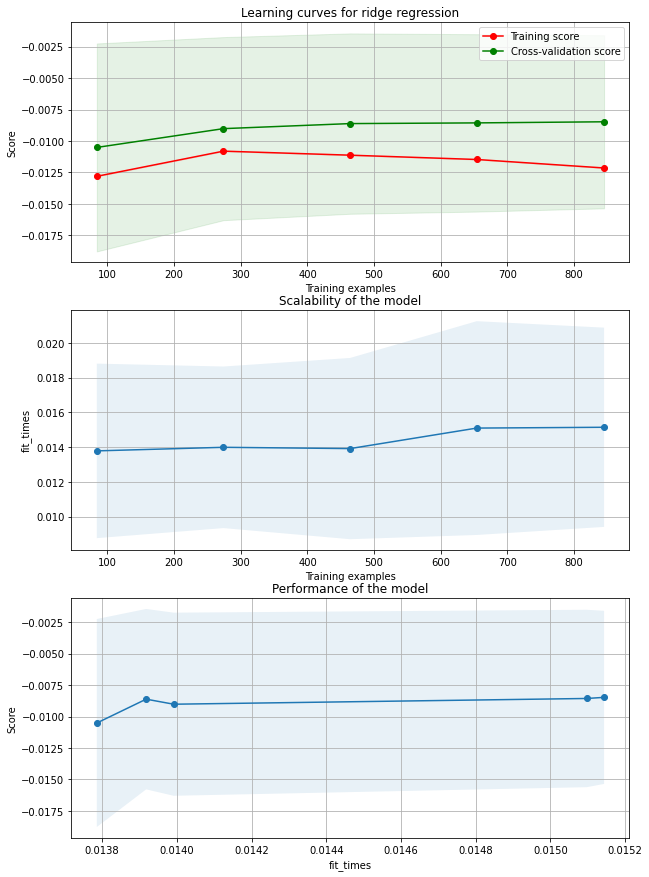

In [35]:
fig, axes = plt.subplots(3, 1, figsize=(10, 15))

title = "Learning curves for ridge regression"

plot_learning_curve(
    best_model, title, X, y, axes=axes, cv=cv, n_jobs=4, scoring=scorer
)


__Dumping the model__

In [36]:
pickle.dump(best_model, open('best_model.pkl', 'wb'))

__Conclusion :__ 
 - Thus, our model is scalable & robust.
 - We get our able to beat the base performance by ~1.5%